## CS Overview

The basic motivation for compressive sensing is that discrete signals, e.g. images, that we typically encounter in practice can be represented in some sparse way using the right basis. Another way of phrasing this is by saying that the information content of the signal is less than the measured data, the signal is compressable. Continuing with the example of images, they are typically sparse when represented in the wavelet domain. What we mean by this idea is that if we have a discrete signal of length $N$, there is some basis such that if we write our signal as a linear combination of the basis components then only $M << N$ coefficients are non zero.

The compressive sensing theory tells us that for signals of this type and under further conditions that we can recover the entire signal from few samples with overwhelming probability through a linear program. Without digging into the details the approach taken is as follows.

Consider a signal $x$ of length $N$ which can be written as the linear combination

$$ x = \psi c $$

where $\psi$ is an $N \times N$ matrix and $c$ is a vector of $N$ coefficients which is sparse. Instead of measuring all $N$ samples required to construct $x$, we measure a random subset $\hat{x}$ of $M$ samples by the operation

$$ \hat{x} = \phi x $$

where $\phi$ is an $M \times N$ matrix with rows constructed by randomly selecting $M$ rows from the identify matrix. note that $\hat{x}$ has length $M$. To recover $x$ from $\hat{x}$ we solve the linear program

$$ \min ||{c}||_{l_1} \quad \text{where} \quad \phi \psi c = \hat{x}$$

Observe that the reason this turns into an optimisation problem is because the linear system is underdetermined; $\phi \psi$ is a map from $N$ to $M$ dimensional space. The matrix $A = \phi \psi$ is referred to as the sensing matrix. 

Once we have a solution $c$, we can recover $x$ from our original relationship where $x = \psi c$.

## CS Example

In this example we explore the idea of compressive sensing in the context of sampling and reconstruction of an analogue signal. More specifically, we investigate the recovery of a signal that has been under sampled according to what classical sampling dictates.

The first step is to import the packages we need. We will be using the DCT to construct our sensing matrix hence the need for ```scipy.fftpack```. The ```cvxpy``` package includes the $l_1$ optimisation we want.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as spfft
import cvxpy as cvx

The analogue signal we will begin with is a periodic function with 3 frequency components.

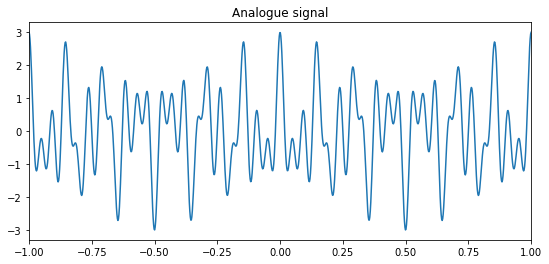

In [2]:
# number of plotting intervals
ppoint = 1000
t = np.linspace(-1, 1, ppoint)

# frequencies present in signal (Hz)
freq = [7, 13, 21]

y = np.cos(2 * np.pi * np.outer(freq, t)).sum(axis = 0)
fig, ax = plt.subplots(1, figsize = (9, 4))
ax.plot(t, y)
ax.set_xlim(t.min(), t.max())
ax.set_title('Analogue signal')
plt.show()

In classical sampling if we want to sample this signal and be able to perfectly reconstruct the signal through sinc interpolation we need to sample at a rate which is at least twice the maximum frequency present. Generally, however, perfect reconstruction, not just frequency content reconstruction, requires higher rates. For this signal we find that a rate of 3 times the highest frequency present does a reasonable job.

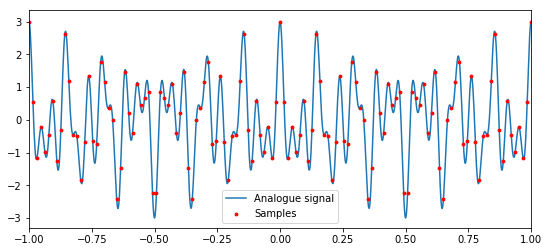

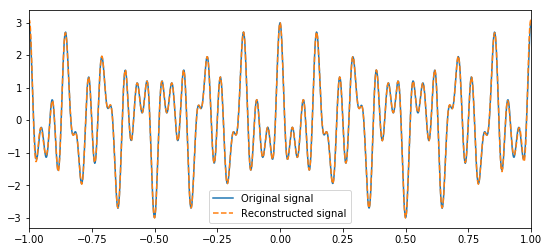

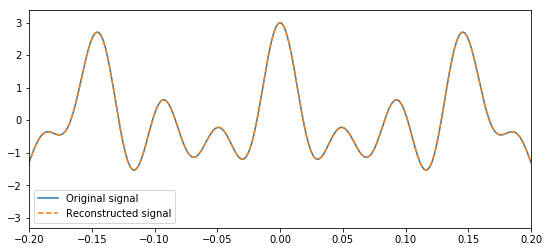

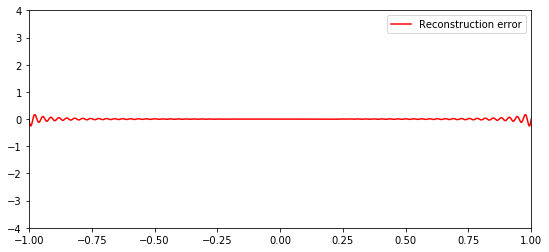

In [3]:
# shannon sampling and reconstruction

fs = 3 * np.max(freq) # sampling frequency
ts = np.arange(-1, 1 + 1 / fs, 1 / fs)
ys = np.cos(2 * np.pi * np.outer(freq, ts)).sum(axis = 0)

fig, ax = plt.subplots(1, figsize = (9, 4))
ax.plot(t, y, zorder = 1)
ax.scatter(ts, ys, color = 'r', s = 8, zorder = 2)
ax.set_xlim(t.min(), t.max())
ax.legend(labels = ['Analogue signal', 'Samples'])

# sinc interpolation
num_cof = len(ts)
recon = 0
for k in range(num_cof):
    recon += ys[k] * np.sinc(k - int(num_cof / 2) - fs * t)
    
fig, ax = plt.subplots(1, figsize = (9, 4))
ax.plot(t, y, zorder = 1)
ax.plot(t, recon, '--', zorder = 2)
ax.set_xlim(t.min(), t.max())
ax.legend(labels = ['Original signal', 'Reconstructed signal'])

fig, ax = plt.subplots(1, figsize = (9, 4))
ax.plot(t, y, zorder = 1)
ax.plot(t, recon, '--', zorder = 2)
ax.set_xlim(t.min() / 5, t.max() / 5)
ax.legend(labels = ['Original signal', 'Reconstructed signal'])

er = y - recon
fig, ax = plt.subplots(1, figsize = (9, 4))
ax.plot(t, er, 'r')
ax.set_xlim(t.min(), t.max())
ax.set_ylim(-4, 4)
ax.legend(labels = ['Reconstruction error'])

plt.show()

When we undersample the signal we end up with a pretty poor reconstruction attempt. The following illustrates what happens if we under sample.

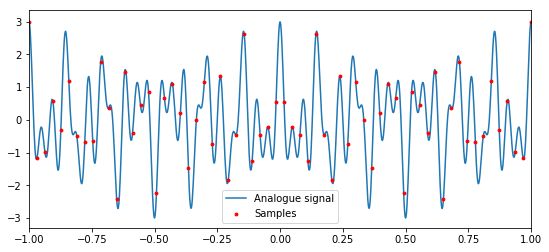

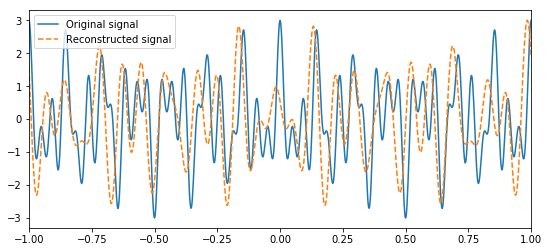

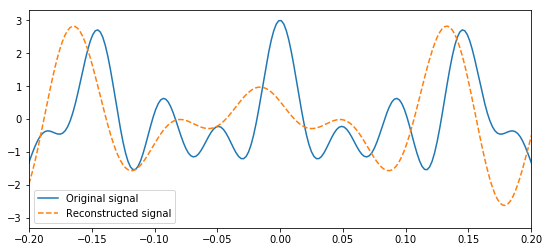

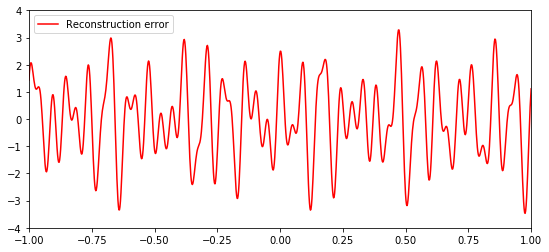

In [4]:
# under sampling

fs_u = 0.5 * fs # sampling frequency
ts_u = np.arange(-1, 1 + 1 / fs_u, 1 / fs_u)
ys_u = np.cos(2 * np.pi * np.outer(freq, ts_u)).sum(axis = 0)

fig, ax = plt.subplots(1, figsize = (9, 4))
ax.plot(t, y, zorder = 1)
ax.scatter(ts_u, ys_u, color = 'r', s = 8, zorder = 2)
ax.set_xlim(t.min(), t.max())
ax.legend(labels = ['Analogue signal', 'Samples'])

# sinc interpolation
num_cof = len(ts_u)
recon = 0
for k in range(num_cof):
    recon += ys_u[k] * np.sinc(k - int(num_cof / 2) - fs_u * t)
    
fig, ax = plt.subplots(1, figsize = (9, 4))
ax.plot(t, y, zorder = 1)
ax.plot(t, recon, '--', zorder = 2)
ax.set_xlim(t.min(), t.max())
ax.legend(labels = ['Original signal', 'Reconstructed signal'])

fig, ax = plt.subplots(1, figsize = (9, 4))
ax.plot(t, y, zorder = 1)
ax.plot(t, recon, '--', zorder = 2)
ax.set_xlim(t.min() / 5, t.max() / 5)
ax.legend(labels = ['Original signal', 'Reconstructed signal'])

er = y - recon
fig, ax = plt.subplots(1, figsize = (9, 4))
ax.plot(t, er, 'r')
ax.set_xlim(t.min(), t.max())
ax.set_ylim(-4, 4)
ax.legend(labels = ['Reconstruction error'])

plt.show()

If we look at the full set of samples obtained by appropriately sampling the signal we see that this set of samples appears to be pseudo sparse in the DCT basis. This suggests that we may be able to recover the full set from a random subset using compressive sensing.

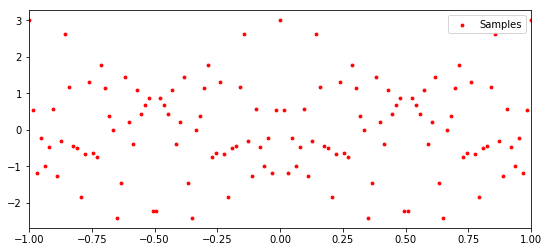

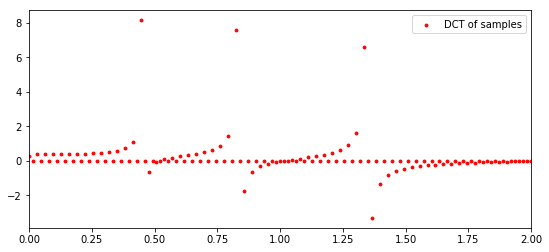

In [5]:
# compressive sensing - pseudo sparseness of samples in DCT basis indicates compressibility

fig, ax = plt.subplots(1, figsize = (9, 4))
ax.scatter(ts, ys, color = 'r', s  = 8, zorder = 2)
ax.set_xlim(t.min(), t.max())
ax.legend(labels = ['Samples'])

ts_dct = np.linspace(0, 2, len(ys))
ys_dct = spfft.dct(ys, norm = 'ortho')

fig, ax = plt.subplots(1, figsize = (9, 4))
ax.scatter(ts_dct, ys_dct, color = 'r', s  = 8, zorder = 2)
ax.set_xlim(0, t.max() - t.min())
ax.legend(labels = ['DCT of samples'])

plt.show()


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +4e+02  9e-01  1e-02  1e+00  1e+00    ---    ---    1  1  - |  -  - 
 1  +2.074e+01  +2.077e+01  +9e+01  4e-01  3e-03  3e-01  3e-01  0.8135  6e-02   0  0  0 |  0  0
 2  +2.601e+01  +2.604e+01  +5e+01  2e-01  1e-03  2e-01  2e-01  0.5987  3e-01   1  0  0 |  0  0
 3  +2.848e+01  +2.849e+01  +2e+01  5e-02  4e-04  5e-02  6e-02  0.8686  2e-01   1  0  0 |  0  0
 4  +2.986e+01  +2.987e+01  +3e+00  9e-03  9e-05  1e-02  1e-02  0.8163  2e-02   1  0  1 |  0  0
 5  +3.003e+01  +3.003e+01  +1e+00  4e-03  4e-05  5e-03  6e-03  0.6794  2e-01   1  1  1 |  0  0
 6  +3.014e+01  +3.014e+01  +3e-01  1e-03  1e-05  1e-03  1e-03  0.7993  4e-02   1  1  1 |  0  0
 7  +3.017e+01  +3.017e+01  +8e-02  2e-04  2e-06  3e-04  3e-04  0.9858  2e-01   1  1  1 |  0  0
 8  +3.017e+01  +3.017e+01  +2e-02  6e-05  5e-

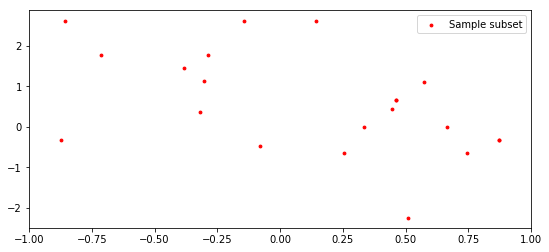

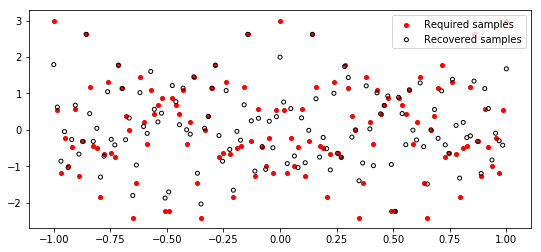

In [6]:
# select a random subset of samples, less than 20% required for faithful reconstruction

idx = np.random.choice(len(ts), int(len(ts) / 6), replace = 'False')
ts_sub = ts[idx]
ys_sub = ys[idx]

fig, ax = plt.subplots(1, figsize = (9, 4))
ax.scatter(ts_sub, ys_sub, color = 'r', s  = 8, zorder = 2)
ax.set_xlim(t.min(), t.max())
ax.legend(labels = ['Sample subset'])

# construct sensing matrix
A = spfft.dct(np.identity(len(ts)), norm = 'ortho', axis = 0)[idx]

# solve l1 norm minimising linear program to recover full set of samples
ts_sol = cvx.Variable(len(ts))
objective = cvx.Minimize(cvx.norm(ts_sol, 1))
constraints = [A*ts_sol == ys_sub]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose = True)

# move solution from frequency domain to time domain
cof = np.squeeze(np.array(ts_sol.value))
ys_sol = spfft.dct(cof, norm = 'ortho')

fig, ax = plt.subplots(1, figsize = (9, 4))
ax.scatter(ts, ys, color = 'r', s = 16, zorder = 1)
ax.scatter(ts, ys_sol, color = 'k', s = 16, facecolors = 'none', zorder = 2)
ax.legend(labels = ['Required samples', 'Recovered samples'])

plt.show()

Clearly a perfect recovery hasn't occured. What happens if we now use these recovered samples and attempt to recover the analogue signal through sinc interpolation?

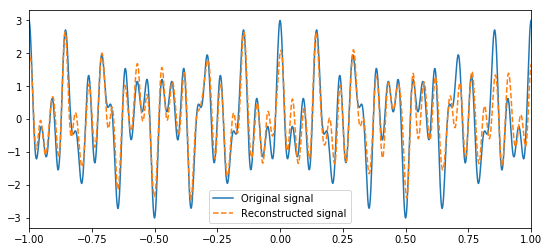

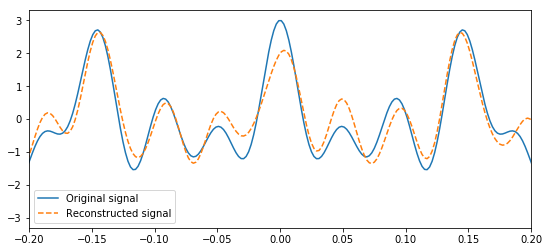

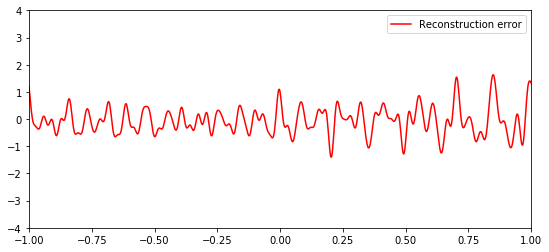

In [7]:
# use recovered samples for sinc interpolation to recover analogue signal
num_cof = len(ts)
recon = 0
for k in range(num_cof):
    recon += ys_sol[k] * np.sinc(k - int(num_cof / 2) - fs * t)
    
fig, ax = plt.subplots(1, figsize = (9, 4))
ax.plot(t, y, zorder = 1)
ax.plot(t, recon, '--', zorder = 2)
ax.set_xlim(t.min(), t.max())
ax.legend(labels = ['Original signal', 'Reconstructed signal'])

fig, ax = plt.subplots(1, figsize = (9, 4))
ax.plot(t, y, zorder = 1)
ax.plot(t, recon, '--', zorder = 2)
ax.set_xlim(t.min() / 5, t.max() / 5)
ax.legend(labels = ['Original signal', 'Reconstructed signal'])

er = y - recon
fig, ax = plt.subplots(1, figsize = (9, 4))
ax.plot(t, er, 'r')
ax.set_xlim(t.min(), t.max())
ax.set_ylim(-4, 4)
ax.legend(labels = ['Reconstruction error'])

plt.show()

Compare this to the result obtained by simply sampling and reconstructing at half the frequency required for faithful reconstruction. Clearly the compressed sensing has yielded a remarkably improved result and yet using 1/3 the same number of sample points we had when under sampling and 1/6 the number of points required for a faithful reconstruction.